# Feedforward Neural Network from scratch for Text Classification

### Contents

1. Goal
2. Approach
3. Dataset

### 1. Goal

- The goal of this notebook is to develop a Feedforward Neural Netowork from scratch for text classification.



### 2. Approach

- Transform raw text data into input vectors


- Implement Feedforward network with
    - Input: Embedding weight matrix
    - Interim: Hidden layer(S)
    - Output: softmax
    
    
- Implement Stochastic Gradient Descent (SGD) algorithm with
    - Forward pass to compute intermediate outputs
    - Backward pass (Backpropagation) to compute gradients and update weights of the network
    - Dropout for regularisation
    - Perform hyperparater tuning
        - dropout rate
        - embedding size
        - Learning rate
    - Plot the learning process
        - training loss
        - validation loss
        
        
- Implement pre-trained word embeddings (GloVe)
    - Reinitialise network weights with pre-trained word embeddings from GloVe
    - Don't update weight during training (weight freezing, NO backpropagation)
    - Perform hyperparameter tuning
    - Plot the learning process
    
    
- Implement More hidden layers


### 3. Dataset

#### AG News Corpus
- The data is taken from [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html).
    - Created folder structure:
        - `data/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
        - `data/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
        - `data/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

#### GloVe Embeddings

- The pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) is available from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip).


In [1]:
!pip install matplotlib==3.3.2

In [2]:
# Important python libraries

import pandas as pd
import numpy as np
import random
import re
from collections import Counter
from tqdm import tqdm
from tqdm.notebook import tnrange
import matplotlib.pyplot as plt
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
# Set random seed for reproducibility
def set_seed():
    random.seed(123)
    np.random.seed(123)
    
set_seed()

### Transform raw text data into input vectors

- Transform the raw text into train, dev, and test sets
- Since the dataset done't have headers, we will first create custome headers and then load the data

In [4]:
# Create a customer Header
news_header = ["label", "text"]

# Load news data
news_train = pd.read_csv('./data/train.csv', names=news_header)
news_dev = pd.read_csv('./data/dev.csv', names=news_header)
news_test = pd.read_csv('./data/test.csv', names=news_header)


In [5]:
# Check the data
news_train.head(5)

,label,text
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [6]:
news_dev.head(5)

,label,text
0,1,"BAGHDAD, Iraq - An Islamic militant group that..."
1,1,Parts of Los Angeles international airport are...
2,1,AFP - Facing a issue that once tripped up his ...
3,1,The leader of militant Lebanese group Hezbolla...
4,1,JAKARTA : ASEAN finance ministers ended a meet...


In [7]:
news_test.head(5)

,label,text
0,1,Canadian Press - VANCOUVER (CP) - The sister o...
1,1,AP - The man who claims Gov. James E. McGreeve...
2,1,"NAJAF, Iraq - Explosions and gunfire rattled t..."
3,1,"LOURDES, France - A frail Pope John Paul II, b..."
4,1,Supporters and rivals warn of possible fraud; ...


Separate the features and lables lists for train, dev, and test sets

In [8]:
news_Xtrain = news_train['text'].tolist()
news_Xdev = news_dev['text'].tolist()
news_Xtest = news_test['text'].tolist()

news_ytrain = news_train['label'].to_numpy()
news_ydev = news_dev['label'].to_numpy()
news_ytest = news_test['label'].to_numpy()


In [9]:
# Check the size of the new datasets
print(len(news_Xtrain))
print(len(news_ytrain))
print(len(news_Xdev))
print(len(news_ydev))
print(len(news_Xtest))
print(len(news_ytest))

2400
2400
150
150
900
900


### Implement Feedforward network

**Create input representations**
- To build a Feedforward neural network, the input data representation needs to be obtained in two ways; from vocabulary or from one-hot encoding. Since, one-hot encoding reqires large memory capacity, we ill repreent the input documents as a list of vocabulary indices where each wrod corresponds to a vocabulary index.

**Text pre-processing pipeline**
- To obtrain the vocabulary of words, we will create text pre-processing pipeline as below:
    - Tokenise all texts into a list of unigrams
    - Remove stop words
    - Remove unigrams appearing in less than K documents
    - Use the remaining unigrams to create the vocabulary of top-N most frequent unigrams in the entire corpus

In [10]:
# Create the stop words list
stop_words = ['a', 'i', "i'm", 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 
              'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 
              'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 
              'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 
              'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 
              'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 
              'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 
              'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 
              'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
              'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 
              'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 
              'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 
              'each', 'few', 'more', 'most', 'other', 'some', 'such', 
              'only', 'own', 'same', 'so', 'than', 'too', 'very', 'can', 'will', 
              'just', 'should', "should've", 'now', 'll', 're', 
              've', 'ma', ".", ",", "would", "could", "must", "shall", "may"]

### Unigram extraction from a document


Implement ngram extraction function `extract_ngrams` where 
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams being extracted (e.g. (1,2) denotes extracting unigrams and bigrams)
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that the data is already tokenised so we will use white space tokenisation
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features
    
and return 
- list of all extracted features    

In [11]:
# Implement ngram extraction
def extract_ngrams(x_raw, ngram_range=(1,3), 
                  token_pattern=f'\b[A-Za-z][A-Za-z]+\b',
                 stop_words=[], vocab=set()):
    token_regex = re.compile(token_pattern)
    
    # Extract all unigrams by tokenising
    x_unigram = [w for w in token_regex.findall(str(x_raw).lower(),) if w not in stop_words]
    
    # Store the unigrams to be returned
    x = []
    if ngram_range[0] == 1:
        x = x_unigram
    
    # Generate n-grams from avaialbe unigrams
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):
        if n==1: 
            continue
        
        # Pass a list of lists as an argument for zip
        arg_list = [x_unigram]+[x_unigram[i:] for i in range(1, n)]
        
        # extract tuples of n-grams using zip
        # for bigram this should look: list(zip(x_uni, x_uni[1:]))
        # align each item x[i] in x_uni with the next one x[i+1]. 
        # Note that x_uni and x_uni[1:] have different lenghts
        # but zip ignores redundant elements at the end of the second list
        # Alternatively, this could be done with for loops
        x_ngram = list(zip(*arg_list))
        ngrams.append(x_ngram)
    
    for n in ngrams:
        for t in n:
            x.append(t)
            
    if len(vocab)>0:
        x=[w for w in x if w in vocab]
    
    return x



### Create a vocabular of n-grams

Implement `get_vocab` function, where
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams being extracted (e.g. (1,2) denotes extracting unigrams and bigrams)
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency
- `keep_topN`: keep top-N more frequent ngrams

and return
- `vocab`: a set of n-grams that will be used as features
- `df`: a document frequency dictionay that contains ngrams as key and their corresponding document frequenciy as values
- `ngram_counts`: counts of each ngram in vocab

In [12]:
def get_vocab(X_raw, ngram_range=(1,3),
             token_pattern=r'\b[A-Za-z][A-Za-z]+\b',
             min_df=0, keep_topN=0, stop_words=[]):

    token_regex = re.compile(token_pattern)
    df = Counter()
    ngram_counts = Counter()
    vocab = set()
    
    # Iterate through each raw text
    for x in X_raw:
        x_ngram = extract_ngrams(x, ngram_range=ngram_range, 
                                 token_pattern=token_pattern, 
                                 stop_words=stop_words)
        # Update document frequency and ngram count
        df.update(list(set(x_ngram)))
        ngram_counts.update(x_ngram)
        
    # Obtain vocabulary as a set with document frequency > min document frequency
    vocab = set([w for w in df if df[w]>=min_df])
    
    # Keep the top N most frequent vocab
    if keep_topN:
        vocab =set([w[0] for w in ngram_counts.most_common(keep_topN)
                   if w[0] in vocab])
        
    return vocab, df, ngram_counts
        

### Get the vocab

In [13]:
keep_topN = 2000
ngram_range = (1,1)
min_df = 0
(vocab_set,
df,
ngram_counts) = get_vocab(news_Xtrain, ngram_range=ngram_range,
                          min_df=min_df, keep_topN=keep_topN,
                          stop_words=stop_words)
news_vocab = list(vocab_set)
print(f'news vocab size: {len(news_vocab)}')
print(news_vocab)


news vocab size: 2000
['nestle', 'take', 'walked', 'gone', 'end', 'tickets', 'wall', 'hand', 'billion', 'selection', 'snow', 'mariel', 'proposal', 'figures', 'sources', 'expected', 'day', 'delay', 'center', 'better', 'region', 'captain', 'jersey', 'cost', 'hamid', 'july', 'heard', 'get', 'defeat', 'india', 'tomas', 'president', 'thanou', 'microsoft', 'tenders', 'opponent', 'residents', 'tony', 'cross', 'auction', 'pieter', 'justin', 'job', 'costs', 'rival', 'czech', 'moderate', 'soldier', 'halliburton', 'main', 'decade', 'programs', 'struggled', 'states', 'boxing', 'survived', 'amp', 'part', 'silver', 'philippines', 'earnings', 'kuala', 'coming', 'battled', 'test', 'costco', 'australia', 'following', 'canadian', 'florida', 'phelps', 'ways', 'super', 'affair', 'kept', 'sixth', 'israeli', 'quarter', 'friends', 'hong', 'andy', 'improved', 'large', 'linked', 'advanced', 'market', 'rest', 'pass', 'criticism', 'died', 'minister', 'punta', 'response', 'francisco', 'kobe', 'defense', 'east', '

As far as vocabulary size is concerned, the larger vocabulary gives larger breadth of words to be picked up during training. However, for this experiment, I have restricted to size 2000. In the upcoming section, we will do hyperparameter tuning during training to get the reasonable accuracy while using this vocabulary.

In [14]:
# Create word to id dictionary for future use
word2id = dict(zip(news_vocab, range(len(news_vocab))))

### Convert the list of unigrams  into a list of vocabulary indices
- Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

- Implement a function `extract_ngrams_for_train_dev_test_sets` to represent documents in train, dev and test sets as lists of words in the vocabulary, where
    - `ngram_range`: a tuple of two integers denoting the type of ngrams being extracted (e.g. (1,2) denotes extracting unigrams and bigrams)
    - `vocab`: a vocabulary set
- and returns
    - `Xtrain_ngrams`: ngrams for train set
    - `Xdev_ngrams`: ngrams for dev set
    - `Xtest_ngrams`: ngrams for test set
    

In [15]:
def extract_ngrams_for_train_dev_test_sets(ngram_range, vocab):
    Xtrain = news_Xtrain
    Xdev   = news_Xdev
    Xtest  = news_Xtest
    
    # Extract n-grams for training set
    Xtrain_ngrams = list()
    for i in tnrange(len(Xtrain)):
        Xtrain_ngrams.append(extract_ngrams(Xtrain[i], 
                                            ngram_range=ngram_range, token_pattern=r'\b[A-Za-z][A-Za-z]+\b',
                                            stop_words=stop_words, vocab=vocab))
    # Extract n-grams for development set
    Xdev_ngrams = list()
    for i in tnrange(len(Xdev)):
        Xdev_ngrams.append(extract_ngrams(Xdev[i], 
                                            ngram_range=ngram_range, token_pattern=r'\b[A-Za-z][A-Za-z]+\b',
                                            stop_words=stop_words, vocab=vocab))
    # Extract n-grams for test set
    Xtest_ngrams = list()
    for i in tnrange(len(Xtest)):
        Xtest_ngrams.append(extract_ngrams(Xtest[i], 
                                            ngram_range=ngram_range, token_pattern=r'\b[A-Za-z][A-Za-z]+\b',
                                            stop_words=stop_words, vocab=vocab))
        
    return Xtrain_ngrams, Xdev_ngrams, Xtest_ngrams

In [16]:
(news_Xtrain_ngrams, 
 news_Xdev_ngrams, 
 news_Xtest_ngrams) = extract_ngrams_for_train_dev_test_sets(ngram_range, news_vocab)


  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

In [17]:
# Convert into list of indices
news_Xtrain_ngrams_indices = []
for ngrams in news_Xtrain_ngrams:
    news_Xtrain_ngrams_indices.append([word2id.get(ngram, -1) for ngram in ngrams])
    
news_Xdev_ngrams_indices = []
for ngrams in news_Xdev_ngrams:
    news_Xdev_ngrams_indices.append([word2id.get(ngram, -1) for ngram in ngrams])

news_Xtest_ngrams_indices = []
for ngrams in news_Xtest_ngrams:
    news_Xtest_ngrams_indices.append([word2id.get(ngram, -1) for ngram in ngrams])

In [18]:
# check the sample of ngram and corresponging vocabulary index
print(news_Xtrain_ngrams[0])
print(news_Xtrain_ngrams_indices[0])

['reuters', 'venezuelans', 'turned', 'early', 'large', 'numbers', 'sunday', 'vote', 'historic', 'referendum', 'either', 'left', 'wing', 'president', 'hugo', 'chavez', 'office', 'give', 'new', 'mandate', 'next', 'two', 'years']
[463, 557, 1567, 546, 82, 619, 1490, 1836, 1318, 1810, 264, 578, 235, 31, 1201, 688, 601, 1480, 1909, 756, 441, 1113, 135]


# Feedforward Neural Network Architecture

The steps to create Feedforward neural network as as following:

- Pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

- Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

- Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

- During training, $\mathbf{a}_1$ is going to be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

- The network will also be extended to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



Create a new function called `get_weight_matrix` which will be used to initialise weight matrix for Feedforward nueral network. The function takes as input:

- `row_size`: The row size of the weight matrix
- `col_size`: The column size of the weight matrix
- `init_val`: The initialisation values that are used to create a range of values from negative to positive

and returns:
- `init_W`: The weight matrix initialised with default values

In [19]:
def get_weight_matrix(row_size, col_size, init_val):
    init_W = np.zeros((row_size, col_size))
    for j in range(row_size):
        weights = np.array(np.random.uniform(-1 * init_val, init_val, col_size)).astype(np.float32)
        init_W[j] = weights
    return init_W


### Network Training

First we need to define the parameters of our network by initialising the weight matrix. To do this, we will create a function `network_weights` that takes inputs:

- `vocab_size`: The size of the vocabulary
- `embedding_dim`: The size of the word embeddings
- `hidden_dim`: The list of the sizes of hidden layers. Empty if there are not hidden layers between the average embedding and the output layer
- `num_classes`: The number of classes for the output layer

and returns:
- `W`: A dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers

Note: We have to make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise the forward and backward pass won't be able to perform. We will also consider using `np.float32` precision to save memory.

In [20]:
def network_weights(vocab_size=1000, embedding_dim=300,
                   hidden_dim=[], num_classes=3, init_val=0.5):
    
    # initialise weights
    W = []
    
    # input layer weight matrix for word embeddings
    W.append({
        "embedding_matrix": get_weight_matrix(vocab_size, embedding_dim, init_val)
    })
    
    # hidden layer weight matrix
    row_size = embedding_dim
    for j in range(len(hidden_dim)):
        col_size = hidden_dim[j]
        W.append({"weights": get_weight_matrix(row_size, col_size, init_val)})
        row_size = col_size
        
    # output layer weight matrix
    col_size = num_classes
    W.append({"weights": get_weight_matrix(row_size, col_size, init_val)})
    
    return W
    
    
    

In [21]:
# sanity check to see the network weight generation and their dimensions
print(network_weights(vocab_size=3, embedding_dim=4, hidden_dim=[2], num_classes=2))

[{'embedding_matrix': array([[ 0.19646919, -0.21386066, -0.27314854,  0.05131477],
       [ 0.21946897, -0.07689354,  0.48076421,  0.18482974],
       [-0.0190681 , -0.10788248, -0.15682198,  0.22904971]])}, {'weights': array([[-0.06142776, -0.4403221 ],
       [-0.10195574,  0.2379954 ],
       [-0.31750828, -0.32454824],
       [ 0.03155137,  0.03182759]])}, {'weights': array([[0.13440096, 0.34943178],
       [0.22445533, 0.11102351]])}]


### softmax function

Due to floating point limitations in numPy, softmax frequently gets `NaN` and `inf` error. To eliminate this error, a softmax normalisation technique is used by subtracting the maximum value of z from the given z value. This way, softmax is normalised across all values for every forward pass and will not generate the errors.

In [22]:
def softmax(z):
    z = z - np.max(z)
    return np.exp(z) / np.sum(np.exp(z))

### Categorical Loss function

The categorical loss function is used to calculate the objective loss during training.

In [23]:
def categorical_loss(X, Y, W):
    losses = list()
    num_classes = 3
    for i, x in enumerate(X):
        out_vals = forward_pass(x, W, dropout_rate=0.0)
        
        # one-hot vector to represent the correct class during categorical loss calculation
        y = one_hot_vector(Y[i]-1, num_classes)
        loss = -y * np.log(out_vals['y_pred'].T)
        losses.append(np.sum(loss.T))
    return np.mean(losses)


### Categorical Loss Derivative function

We need to also create the derivative function to calculate the derivative of categorical loss during backward pass (aka. backpropagation).

In [24]:
def categorical_loss_derivative(y, y_preds):
    loss_der = y_preds.T - y
    return loss_der.T

### ReLU and ReLU Derivative function

We will not implement `relu` function to introduce non-liniearity afte hidden layers. This function will at as activation function during forward pass.

$$relu(z_i)= max(z_i,0)$$

And the `relu_derivative` function is used to compute its derivative during backward pass (aka. backpropagation)

  $$relu\_derivative(z_i)=0$$ if $z_i$<=0, 1 otherwise.
  
Note: Both function take as input a vector $z$.

In [25]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    dz = np.copy(z)
    dz[np.where(dz>0)] = 1
    dz[np.where(dz<=0)] = 0
    return dz

A derivative of ReLU is differentiable at all points except at 0. The left derivative at z<0 is 0 and right derivative at z>0 is 1. But derivative at z=0 is technically undefined. In Colloquial terms, the function is not smooth at z=0 and there are many possible lines (slops) we could fit through. So that do we do here? Basically, we can arbitrarily choose a value as 0, 0.5, or 1 but for simplicity we can choose 0 for z=0.

### Dropout mask

During training, we will apply dropout mask element-wise to do model finetuning to avoid overfitting. This masking will be done after the ReLU activation function (i.e. vector of ones with random percentage set to zero).

In [26]:
def dropout_mask(size, dropout_rate):
    dropout_vec = np.ones((size))
    idx = np.random.choice(len(dropout_vec), 
                          size=int(dropout_rate * size), 
                          replace=False)
    dropout_vec[idx] = 0
    return dropout_vec

In [27]:
# sanity check
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]


### Weight submatrix

Create `weight_submatrix` function that is used to generate the word embedding matrix for the given set of word indexes.

This function consists of inputs

- `x`: The input word index list
- `w_emb`: the embedding weight matrix that consists of word indexes and correspoding weight values

and returns

- `w_sub_mat`: The newly generated word embedding submatrix for given indexes

In [28]:
def weight_submatrix(x, w_emb):
    w_sub_mat = np.array([])
    
    # Iterate through all the word indexes and lookup into weight matrix 
    # to fetch the correct embedding vector based on the index.
    for word_inx in x:
        
        # find word embedding by index
        word_w = w_emb[word_inx]
        
        # accummulate
        w_sub_mat = np.append(w_sub_mat, word_w)
        
    w_sub_mat.shape = (int(len(w_sub_mat) / w_emb.shape[1]), w_emb.shape[1])
    return w_sub_mat

### Forward pass function

We are going to implement the `forward_pass` function that will pass the input through the feedforward neural network upto output layer for computing the probability of expected class using the weight matrix, ReLU activation function and softmax output function. The funtion consists of inputs

- `x`: A list of vocabulary indices of the words belonging to the document
- `W`: A list of weight matrix connecting each part of the network; e.g. W[0] is the weight matrix for connection between input and first hidden layer, W[1] is for connection between first hidden and the next next one.
- `dropout_rate`: The dropout rate that is used to generate a random dropout mask vetor applied after each hidden layer for regularisation.

and returns
- `out_vals`: A dictionary of output value from each layer. Where layers are
    - `h`: The vector before activation function
    - `a`: The resulting vector after passring `h` from activation function
    - dropout mask vector
    - prediction vector: probability for each class from the output layer

In [29]:
def forward_pass(x, W, dropout_rate=0.2):
    bias = 0
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    ones_vector = np.ones((len(x), 1))
    x_in = x
    
    # Iterate through hidden layers
    for layer_idx, w in enumerate(W):
        
        # Compute softmax for the last layer and break the loop
        if layer_idx == len(W) - 1:
            y_pred = softmax(np.dot(w.get('weights').T, x_in) + bias)
            break
        
        # Compute the mean embedding vector of all words for the first hidden layer
        elif layer_idx == 0:

            # Lookup into weight embeddings and create weight submatrix for a given input (list of word indexes)
            weights = weight_submatrix(x_in, w.get('embedding_matrix'))

            # Compute the mean embedding vector for first hidden layer
            h = (np.dot(weights.T, ones_vector) / len(x_in)) + bias

        # Compute the dot product between weight matrix and input for the rest of hidden layers
        else:
            h = np.dot(w.get('weight').T, x_in) + bias

        # Apply ReLU activation function
        a = relu(h)

        # Apply dropout mask on ReLU activation function for hidden layer only
        dropout = dropout_mask(h.shape[0], dropout_rate)
        a = np.multiply(dropout.reshape(len(dropout), -1), a)
        x_in = a

        # Accumulate
        h_vecs.append(h)
        a_vecs.append(a)
        dropout_vecs.append(dropout)
    
    out_vals = {}
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout'] = dropout_vecs
    out_vals['y_pred'] = y_pred
    
    return out_vals
        

In [30]:
''' 
Creat one hot matrix function to generate one hot matrix for updating
the gradients of weights during backward pass
'''
def one_hot_matrix(x, vocab_size):
    ohm =np.zeros((len(x), vocab_size))
    for i, o in enumerate(ohm):
        o[x[i]] = 1
    return ohm

Create a `one_hot_vector` function which is used to generate the vector of true lables which will then be compared with the predicted lables to calculate categorical loss OR derivative of categorical loss. The function takes as input:

- `idx`: And index of the true class
- `size`: The vector size

and returns:

- `x`: The one hot vector

In [31]:
def one_hot_vector(idx, size):
    x = np.zeros(size, dtype=np.int)
    x[idx] = 1
    return x

### Backward pass function

The `backward_pass` function computes the gradients and updates the weights in the network from the output layer to the input layer. It takes inputs
- `x`: A list of vocabulary indices each corresponding to a word in the document (input)
- `y`: The true label
- `W`: A list of weight matrix connecting each part of the network; e.g. W[0] is the weight matrix for connection between input and first hidden layer, W[1] is for connection between first hidden and the next next one.
- `out_vals`: A dictionary of output values from a forward pass
- `lr`: The learning rate that is used during weight updation
- `freeze_emb`: A boolean value indicating whether the embedding weights will be updated or not.

and returns
- `W`: The updated weights of the network

Note: The gradients on the output layer are similary to the multiclass logistic regression.

In [32]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    
    num_classes = 3
    
    # One hot vector to represent the correct classes for calculating categorical loss derivative
    y_onehot = one_hot_vector(y-1, num_classes)
    
    # Compute gradient on output layer (dy_hatL)
    g = categorical_loss_derivative(y_onehot, out_vals.get("y_pred"))
    
    for k in reversed(range(len(W))):
        if k == len(W)-1:
            # Compute weights gradients (ghk-1)
            d_wkL = np.dot(out_vals.get("a")[k-1], g.T)
        else:
            # Element-wise multiplication (g.f'(zk))
            g = g * relu_derivative(out_vals.get("h")[k])
            if k>0:
                # Compute weights gradients (ghk-1)
                d_wkL = np.dot(out_vals.get("a")[k-1], g.T)
            
            # Compute gradient only for word embedding updation
            elif k==0 and not freeze_emb:
                g = np.dot(np.ones((len(x), 1)), g.T) / len(x)
        
        if k>0:
            # Compute the gradients w.r.t. next layer (gWk)
            wk = W[k].get("weights")
            g = np.dot(wk, g)
            
            # Apply dropout for backward pass
            dropout = out_vals["dropout"][k-1]
            g = np.multiply(dropout.reshape(len(dropout), -1), g)
            W[k]["weights"] = wk - (lr * d_wkL)
    
    # Update word embeddings
    if not freeze_emb:
        d_wkL = np.dot(one_hot_matrix(x, len(news_vocab)).T, g)
        uniqueIdx = list(set(x))
        W[k]["embedding_matrix"][uniqueIdx] -= lr * d_wkL[uniqueIdx]    # Wk-lr*d_wkL
    
    return W
    

**Observations**

- Dropout mask:
    - Dropout is used for regularisation, and it makes network less prone to overfitting. During dropout we kill the neurons during forward pass. Since the killed neurons don't contribue to the network learing process, we don't flow the gradients through them while during backward pass. Hence, it is important to apply the dropout mask just before calculating the gradient with respect to the next hidden layer (gWk) in backward pass and kill the same neuron again.
    - The dropout mask for forward and backward pass is the same.

- Word embedding updation:
    - In order to optimise the processing time, a one hot matrix is used. This allows us to update only relevant unique indexes with resepct to the given document(x). See the logic where `W[k]["embedding_matrix"]` is used in `backward_pass` function.
    
    

### Shuffle function

We will now create a `shuffle` function that is used to shuffle the dataset before starting the training. This would ensure that the dataset is generalised during training in order to avoid the overfitting. The function take inputs:

- `X`: A list of word indexes of the training dataset
- `Y`: A list of labels of the training dataset corresponding to given X

and returns:

- `X_shuffled`: The shuffled list of `X`
- `Y_shuffled`: The shuffled list of `Y` corresponding to the respective `X`

In [33]:
def shuffle(X, Y):
    indexes = np.arange(len(X))
    np.random.shuffle(indexes)
    X_shuffled = X[indexes]
    Y_shuffled = Y[indexes]
    return X_shuffled.tolist(), Y_shuffled.tolist()

In [34]:
def on_hot_vector(idx, size):
    x = np.zerors(size, dtype=np.int)
    x[idx] = 1
    return x

### Stochastic Gradient Descent function

We are going to create a stochastic gradient descent function `SGD` to support back-propagation by using the `forward_pass` and `backward_pass` function. It takes as inputs:
- `X_tr`: A vector of training data
- `Y_tr`: A vector of labels for training data
- `W`: The weights of the network (dictionary)
- `X_dev`: A vector of dev data
- `Y_dev`: A vector labels for dev data
- `lr`: Learning rate
- `dropout`: Regularisation strength
- `epochs`: Number of full passes over the training data
- `tolerance`: Stop training if the difference between the current and previous vaildation loss is smaller than the threshold
- `freeze_emb`: A boolean value indicating whether the embedding weights will be updated or not
- `print_progress`: Flag for printing the training progress

and returns:
- `weights`: The learned weights
- `training_loss_history`: A vector of the average losses of the entire training set after each epoch
- `validation_loss_history`: A vector of the average losses of the entire validation set after each epoch

In [35]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, dropout=0.2, 
        epochs=5, tolerance=0.001, freeze_emb=False, print_progress=True):
    
    training_loss_history = []
    validation_loss_history = []
    
    # Randomise the order of the training dataset
    X_tr, Y_tr = shuffle(np.array(X_tr, dtype=object), np.array(Y_tr))
        
    for epoch in tnrange(epochs, desc="Epochs"):
        
        # Iterate through the dataset
        for i, x in enumerate(X_tr):
            
            # Forward pass
            out_vals = forward_pass(x, W, dropout_rate=dropout)
            
            # Backward pass
            W = backward_pass(X_tr[i], Y_tr[i], W, out_vals, lr, freeze_emb)
            
        # Calculate loss
        train_loss = categorical_loss(X_tr, Y_tr, W)
        val_loss = categorical_loss(X_dev, Y_dev, W)
        
        if print_progress:
            diff = 0.0
            if epoch > 0:
                diff = np.abs(val_loss - validation_loss_history[-1])
            
            if (epoch > 0 and val_loss <0.5 and diff <= tolerance):
                print(f'{epoch + 1}, Training Loss: {train_loss:.5f}, Validation Loss: {val_loss:.5f}, Diff(Val Loss): {diff:.5f}')
                print('Tolerance encountered. Stop the training.')
                break
            if (int((epoch+1)%5)) == 0:
                print(f'{epoch + 1}, Training Loss: {train_loss:.5f}, Validation Loss: {val_loss:.5f}, Diff(Val Loss): {diff:.5f}')
        
        training_loss_history.append(train_loss)
        validation_loss_history.append(val_loss)

    return W, training_loss_history, validation_loss_history


In [36]:
# We will now create the function to plot the losses
def plot_loss(loss_tr, loss_val):
    fig, ax = plt.subplots(1, figsize=(10,5))
    ax.plot(loss_tr, color='red', label='Training Loss')
    ax.plot(loss_val, color='blue', label='Validation Loss')
    ax.set_title("Epoch-wise loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
    SMALL_SIZE=12
    MEDIUM_SIZE=14
    BIGGER_SIZE=16

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    plt.show()

We are not ready to train and evaluate our Feedforward neural network.

In [37]:
def train_and_evaluate(params_list, embedding_matrix=None):
    for i, params in enumerate(params_list):
        
        # Resetting seed because of randomness processing
        set_seed()
        
        print(f'\n')
        print(f'params: {json.dumps(params, indent=4)}')
        
        # Define network weights
        W = network_weights(vocab_size=params["vocab_size"],
                            embedding_dim=params["embedding_dim"],
                            hidden_dim=params["hidden_dim"],
                            num_classes=params["num_classes"],
                            init_val=params["init_val"])
        
        # Print network weights
        for i in range(len(W)):
            if i==0:
                print(f'Shape W{str(i)}, {W[i]["embedding_matrix"].shape}')
            else:
                print(f'Shape W{str(i)}, {W[i]["weights"].shape}')
        
        # Replace the weights of the embedding matrix
        if embedding_matrix is not None:
            W[0]["embedding_matrix"] = embedding_matrix
            
        
        # Train the model
        W, loss_tr, loss_val = SGD(X_tr=news_Xtrain_ngrams_indices, 
                                   Y_tr=news_ytrain, W=W,
                                   X_dev=news_Xdev_ngrams_indices,
                                   Y_dev=news_ydev,
                                   lr=params["lr"],
                                   dropout=params["dropout"],
                                   freeze_emb=params["freeze_emb"],
                                   tolerance=params["tolerance"],
                                   epochs=params["epochs"])
        print("Learning process:\n")
        plot_loss(loss_tr, loss_val)
        
        print("Compute accuracy, precision, recall, and F1-score:\n")
        X_te = news_Xtest_ngrams_indices
        Y_te = news_ytest
        pred_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_pred'])+1 for x,y in zip(X_te, Y_te)]
        
        print(f"Accuracy: {accuracy_score(Y_te, pred_te)}")
        print(f"Precision: {precision_score(Y_te, pred_te, average='macro')}")
        print(f"Recall: {recall_score(Y_te, pred_te, average='macro')}")
        print(f"F1-score: {f1_score(Y_te, pred_te, average='macro')}")
        
        



params: {
    "vocab_size": 2000,
    "embedding_dim": 100,
    "hidden_dim": [],
    "lr": 0.01,
    "dropout": 0.0,
    "tolerance": 0.0001,
    "epochs": 200,
    "freeze_emb": false,
    "init_val": 0.1,
    "num_classes": 3
}
Shape W0, (2000, 100)
Shape W1, (100, 3)


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

5, Training Loss: 1.08259, Validation Loss: 1.08921, Diff(Val Loss): 0.00340
10, Training Loss: 0.95554, Validation Loss: 1.01122, Diff(Val Loss): 0.03028
15, Training Loss: 0.66523, Validation Loss: 0.76548, Diff(Val Loss): 0.05261
20, Training Loss: 0.42588, Validation Loss: 0.51929, Diff(Val Loss): 0.04160
25, Training Loss: 0.28813, Validation Loss: 0.38814, Diff(Val Loss): 0.01832
30, Training Loss: 0.21435, Validation Loss: 0.32857, Diff(Val Loss): 0.00874
35, Training Loss: 0.16746, Validation Loss: 0.29907, Diff(Val Loss): 0.00445
40, Training Loss: 0.13532, Validation Loss: 0.28395, Diff(Val Loss): 0.00226
45, Training Loss: 0.11217, Validation Loss: 0.27627, Diff(Val Loss): 0.00116
50, Training Loss: 0.09489, Validation Loss: 0.27241, Diff(Val Loss): 0.00056
55, Training Loss: 0.08158, Validation Loss: 0.27043, Diff(Val Loss): 0.00034
60, Training Loss: 0.07108, Validation Loss: 0.26962, Diff(Val Loss): 0.00009
Tolerance encountered. Stop the training.
Learning process:



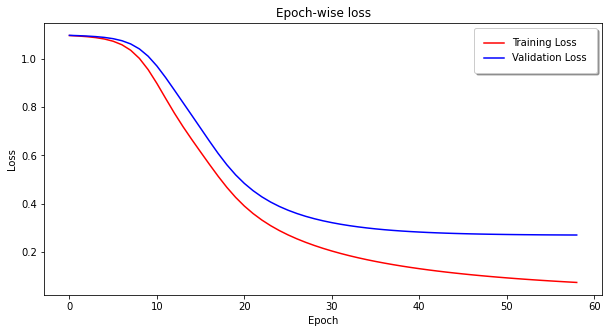

Compute accuracy, precision, recall, and F1-score:

Accuracy: 0.85
Precision: 0.8518875485406152
Recall: 0.85
F1-score: 0.8498986849290119


<ipython-input-29-8279170683c5>:24: RuntimeWarning: invalid value encountered in true_divide
  h = (np.dot(weights.T, ones_vector) / len(x_in)) + bias


In [38]:
params_list = [
    {"vocab_size":len(news_vocab),
     "embedding_dim":100,
     "hidden_dim":[],
     "lr":0.01,
     "dropout":0.0,
     "tolerance":0.0001,
     "epochs":200,
     "freeze_emb":False,
     "init_val":0.1,
     "num_classes":3
    }
]

train_and_evaluate(params_list)